# Test 1

In [1]:
from google.colab import files
uploaded = files.upload()



Saving dosfinal.csv to dosfinal.csv


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("dosfinal.csv")
# OR use your actual filename

print(df.shape)
df.head()


(3129, 10)


,dosef,energy,natom,mass,fmax,smax,hform,volume,gap_nosoc,gap
0,0.0,-16.112529,4,247.734400,0.009337,0.000149,-0.046132,327.286639,0.159791,0.164045
1,0.0,-13.581981,4,279.856400,0.007039,0.000079,0.063505,380.909858,0.967953,0.961595
2,0.0,-12.556373,4,373.678400,0.009621,0.000034,0.022407,401.441237,0.869507,0.750715
3,0.0,-11.852202,4,470.936400,0.007429,0.000021,0.059449,459.020808,0.663121,0.478298
4,0.0,-16.546603,4,425.931138,0.005010,0.000360,-0.009651,322.649929,0.165582,0.175493


In [3]:
print(df.columns.tolist())


['dosef', 'energy', 'natom', 'mass', 'fmax', 'smax', 'hform', 'volume', 'gap_nosoc', 'gap']


In [4]:
# Drop rows with missing SOC or non-SOC bandgaps
df = df.dropna(subset=["gap", "gap_nosoc"])

# Remove non-physical values
df = df[(df["gap"] > 0) & (df["gap_nosoc"] > 0)]

print("After basic cleaning:", df.shape)



After basic cleaning: (901, 10)


In [5]:
# TMDC SOC bandgap window (in eV)
LOW_BG = 0.8
HIGH_BG = 2.5

df = df[(df["gap"] >= LOW_BG) & (df["gap"] <= HIGH_BG)]

print("After TMDC bandgap filtering:", df.shape)


After TMDC bandgap filtering: (415, 10)


In [6]:
features_B = [
    'dosef', 'energy', 'mass',
    'hform', 'volume'
]

X_B = df[features_B]
y = df['gap']




In [7]:
# Install xgboost (Colab usually has it, but this is safe)
!pip install -q xgboost


In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor


In [9]:
# Final feature set (locked)
features = [
    'dosef', 'energy', 'mass',
    'hform', 'volume'
]

X = df[features]
y = df['gap']

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (415, 5)
y shape: (415,)


In [10]:
cv = KFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

In [11]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rmse_rf = -cross_val_score(
    rf,
    X,
    y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

print("Random Forest RMSE:")
print("Mean:", rmse_rf.mean())
print("Std :", rmse_rf.std())


Random Forest RMSE:
Mean: 0.34934991131684445
Std : 0.02023862994357927


In [12]:
gbdt = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=3,
    subsample=0.8,
    random_state=42
)

rmse_gbdt = -cross_val_score(
    gbdt,
    X,
    y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

print("GBDT RMSE:")
print("Mean:", rmse_gbdt.mean())
print("Std :", rmse_gbdt.std())


GBDT RMSE:
Mean: 0.35113563328345887
Std : 0.021296063077248302


In [13]:
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

rmse_xgb = -cross_val_score(
    xgb,
    X,
    y,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

print("XGBoost RMSE:")
print("Mean:", rmse_xgb.mean())
print("Std :", rmse_xgb.std())


XGBoost RMSE:
Mean: 0.3475309612165646
Std : 0.018330871124687564


In [14]:
results = pd.DataFrame({
    "Model": ["Random Forest", "GBDT", "XGBoost"],
    "RMSE_mean": [
        rmse_rf.mean(),
        rmse_gbdt.mean(),
        rmse_xgb.mean()
    ],
    "RMSE_std": [
        rmse_rf.std(),
        rmse_gbdt.std(),
        rmse_xgb.std()
    ]
})

results.sort_values("RMSE_mean")


,Model,RMSE_mean,RMSE_std
2,XGBoost,0.347531,0.018331
0,Random Forest,0.349350,0.020239
1,GBDT,0.351136,0.021296


In [16]:
# Model A (physics-assisted)
features_A = [
    'dosef', 'energy', 'mass',
    'hform', 'volume', 'gap_nosoc'
]

# Model B (discovery)
features_B = [
    'dosef', 'energy', 'mass',
    'hform', 'volume'
]


In [17]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df = pd.read_csv(
    "/content/drive/MyDrive/TMDC_ML_Project/dosfinal_final.csv"
)

X_A = df[features_A]
X_B = df[features_B]
y = df['gap']





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import os

project_path = "/content/drive/MyDrive/TMDC_ML_Project"
os.makedirs(project_path, exist_ok=True)

project_path


'/content/drive/MyDrive/TMDC_ML_Project'

In [19]:
X_A = df[features_A]
X_B = df[features_B]
y = df['gap']

print(X_A.shape, X_B.shape, y.shape)


(415, 6) (415, 5) (415,)


In [20]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df = pd.read_csv(
    "/content/drive/MyDrive/TMDC_ML_Project/dosfinal_final.csv"
)

X_A = df[features_A]
X_B = df[features_B]
y = df['gap']



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!ls /content/drive/MyDrive/TMDC_ML_Project


GBDT_Model_A_with_gap_nosoc.pkl


In [62]:
!ls /content/drive/MyDrive/TMDC_ML_Project



GBDT_Model_A_with_gap_nosoc.pkl


In [63]:
df



,dosef,energy,natom,mass,fmax,smax,hform,volume,gap_nosoc,gap
1,0.0,-13.581981,4,279.856400,7.038859e-03,0.000079,0.063505,380.909858,0.967953,0.961595
5,0.0,-14.780383,4,458.053138,3.891336e-03,0.000229,-0.091096,387.322733,1.282603,1.217789
6,0.0,-13.688473,4,551.875138,9.050766e-03,0.000199,-0.115618,414.249230,1.187794,0.956757
72,0.0,-8.323628,2,101.903133,7.220000e-14,0.000068,0.038686,218.154168,1.239193,1.237287
74,0.0,-7.551540,2,148.741538,3.253097e-03,0.000020,0.296230,261.130516,1.459351,1.453233
...,...,...,...,...,...,...,...,...,...,...
3006,0.0,-29.393208,6,423.608200,8.484018e-03,0.000230,-0.705868,482.927175,0.890953,0.894463
3017,0.0,-28.312196,6,676.596000,8.499557e-03,0.000065,-1.160033,416.926294,0.882080,0.851929
3018,0.0,-31.148112,6,498.780000,8.763757e-03,0.000144,-1.499352,376.428143,0.872065,0.842702
3075,0.0,-31.400893,6,243.683000,7.868177e-03,0.000164,-1.202149,384.218865,1.426806,1.426491


In [21]:
from sklearn.ensemble import RandomForestRegressor
import joblib

rf_A = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rf_A.fit(X_A, y)

joblib.dump(
    rf_A,
    "/content/drive/MyDrive/TMDC_ML_Project/RF_Model_A_with_gap_nosoc.pkl"
)

print("RF Model A saved")



RF Model A saved


In [22]:
rf_B = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rf_B.fit(X_B, y)

joblib.dump(
    rf_B,
    "/content/drive/MyDrive/TMDC_ML_Project/RF_Model_B_without_gap_nosoc.pkl"
)

print("RF Model B saved")



RF Model B saved


In [23]:
from xgboost import XGBRegressor

xgb_A = XGBRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

xgb_A.fit(X_A, y)

joblib.dump(
    xgb_A,
    "/content/drive/MyDrive/TMDC_ML_Project/XGB_Model_A_with_gap_nosoc.pkl"
)

print("XGB Model A saved")



XGB Model A saved


In [24]:
xgb_B = XGBRegressor(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42
)

xgb_B.fit(X_B, y)

joblib.dump(
    xgb_B,
    "/content/drive/MyDrive/TMDC_ML_Project/XGB_Model_B_without_gap_nosoc.pkl"
)

print("XGB Model B saved")


XGB Model B saved


In [25]:
!ls /content/drive/MyDrive/TMDC_ML_Project



dosfinal_final.csv		    RF_Model_B_without_gap_nosoc.pkl
GBDT_Model_A_with_gap_nosoc.pkl     XGB_Model_A_with_gap_nosoc.pkl
GBDT_Model_B_without_gap_nosoc.pkl  XGB_Model_B_without_gap_nosoc.pkl
RF_Model_A_with_gap_nosoc.pkl


In [26]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Load dataset
df = pd.read_csv(
    "/content/drive/MyDrive/TMDC_ML_Project/dosfinal_final.csv"
)

# Model A features
features_A = [
    'dosef', 'energy', 'mass',
    'hform', 'volume', 'gap_nosoc'
]

X = df[features_A].values
y = df['gap'].values

print(df.shape)


(415, 10)


In [28]:
from sklearn.ensemble import GradientBoostingRegressor

def gbdt_uncertainty(X, y, n_models=50):
    preds = []
    for seed in range(n_models):
        model = GradientBoostingRegressor(
            n_estimators=500,
            learning_rate=0.03,
            max_depth=4,
            min_samples_split=5,
            min_samples_leaf=3,
            subsample=0.8,
            random_state=seed
        )
        model.fit(X, y)
        preds.append(model.predict(X))
    preds = np.array(preds)
    return preds.mean(axis=0), preds.std(axis=0)


In [29]:
mean_pred, std_pred = gbdt_uncertainty(X, y)

df["pred_mean"] = mean_pred
df["pred_uncertainty"] = std_pred

print("Mean uncertainty (eV):", std_pred.mean())
print("Median uncertainty (eV):", np.median(std_pred))


Mean uncertainty (eV): 0.005309266607621332
Median uncertainty (eV): 0.0051449736679444824


In [30]:
df.to_csv(
    "/content/drive/MyDrive/TMDC_ML_Project/uncertainty_results_modelA.csv",
    index=False
)


In [31]:
df["abs_error"] = np.abs(df["gap"] - df["pred_mean"])


In [32]:
bins = [0.8, 1.2, 1.6, 2.0, 2.5]
labels = ["0.8–1.2", "1.2–1.6", "1.6–2.0", "2.0–2.5"]

df["gap_bin"] = pd.cut(df["gap"], bins=bins, labels=labels)


In [33]:
error_by_bin = df.groupby("gap_bin")["abs_error"].agg(
    mean_error="mean",
    std_error="std",
    count="count"
)

error_by_bin


/tmp/ipython-input-1273147986.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_bin = df.groupby("gap_bin")["abs_error"].agg(


,mean_error,std_error,count
gap_bin,,,
0.8–1.2,0.021531,0.023834,162
1.2–1.6,0.023327,0.018853,131
1.6–2.0,0.027731,0.025792,69
2.0–2.5,0.019339,0.017204,53


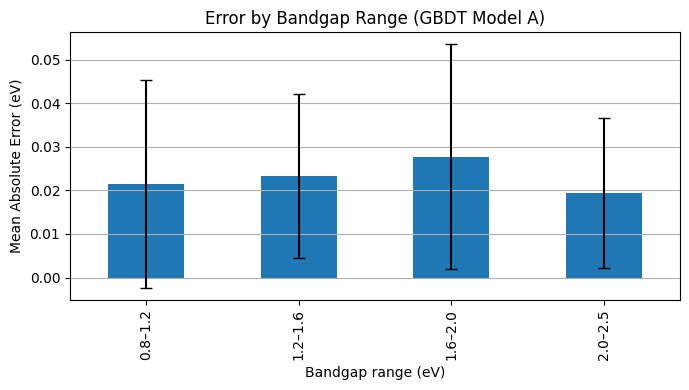

In [34]:
error_by_bin["mean_error"].plot(
    kind="bar",
    yerr=error_by_bin["std_error"],
    capsize=4,
    figsize=(7,4)
)

plt.ylabel("Mean Absolute Error (eV)")
plt.xlabel("Bandgap range (eV)")
plt.title("Error by Bandgap Range (GBDT Model A)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [35]:
error_by_bin.to_csv(
    "/content/drive/MyDrive/TMDC_ML_Project/error_by_bandgap_range.csv"
)


In [36]:
gbdt_A = joblib.load(
    "/content/drive/MyDrive/TMDC_ML_Project/GBDT_Model_A_with_gap_nosoc.pkl"
)

rf_A = joblib.load(
    "/content/drive/MyDrive/TMDC_ML_Project/RF_Model_A_with_gap_nosoc.pkl"
)

xgb_A = joblib.load(
    "/content/drive/MyDrive/TMDC_ML_Project/XGB_Model_A_with_gap_nosoc.pkl"
)


In [37]:
fi = pd.DataFrame({
    "Feature": features_A,
    "GBDT": gbdt_A.feature_importances_,
    "RF": rf_A.feature_importances_,
    "XGB": xgb_A.feature_importances_
})

fi["Mean_importance"] = fi[["GBDT","RF","XGB"]].mean(axis=1)
fi = fi.sort_values("Mean_importance", ascending=False)

fi


,Feature,GBDT,RF,XGB,Mean_importance
5,gap_nosoc,0.831355,0.667035,0.627984,0.708792
1,energy,0.039052,0.111716,0.080812,0.077193
2,mass,0.063810,0.062174,0.091347,0.072444
3,hform,0.024509,0.089245,0.101679,0.071811
4,volume,0.041275,0.069830,0.098177,0.069761
0,dosef,0.000000,0.000000,0.000000,0.000000


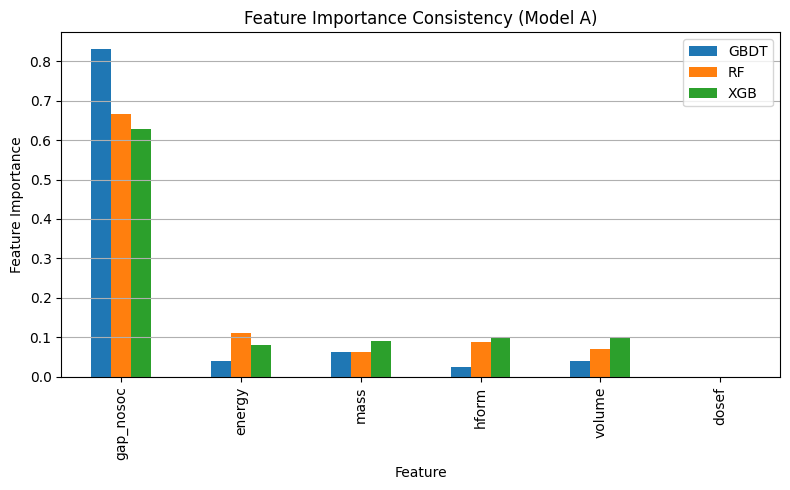

In [38]:
fi.set_index("Feature")[["GBDT","RF","XGB"]].plot(
    kind="bar", figsize=(8,5)
)

plt.ylabel("Feature Importance")
plt.title("Feature Importance Consistency (Model A)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [39]:
fi.to_csv(
    "/content/drive/MyDrive/TMDC_ML_Project/feature_importance_consistency.csv",
    index=False
)


In [40]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import mean_squared_error


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Load dataset
df = pd.read_csv(
    "/content/drive/MyDrive/TMDC_ML_Project/dosfinal_final.csv"
)

features_A = [
    'dosef','energy','mass',
    'hform','volume','gap_nosoc'
]

X = df[features_A]
y_true = df['gap']

# Load Model A
model_A = joblib.load(
    "/content/drive/MyDrive/TMDC_ML_Project/GBDT_Model_A_with_gap_nosoc.pkl"
)

y_pred = model_A.predict(X)


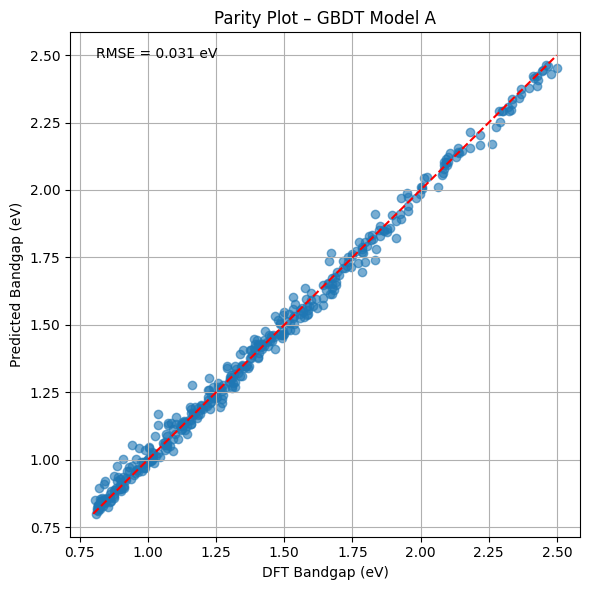

In [43]:
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

rmse = np.sqrt(mean_squared_error(y_true, y_pred))

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)

min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())

plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.text(
    0.05, 0.95,
    f"RMSE = {rmse:.3f} eV",
    transform=plt.gca().transAxes
)

plt.xlabel("DFT Bandgap (eV)")
plt.ylabel("Predicted Bandgap (eV)")
plt.title("Parity Plot – GBDT Model A")
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# Load dataset
df = pd.read_csv(
    "/content/drive/MyDrive/TMDC_ML_Project/dosfinal_final.csv"
)

features_A = [
    'dosef','energy','mass',
    'hform','volume','gap_nosoc'
]

X = df[features_A]
y_true = df['gap']

# Load GBDT Model A
model_A = joblib.load(
    "/content/drive/MyDrive/TMDC_ML_Project/GBDT_Model_A_with_gap_nosoc.pkl"
)

y_pred = model_A.predict(X)


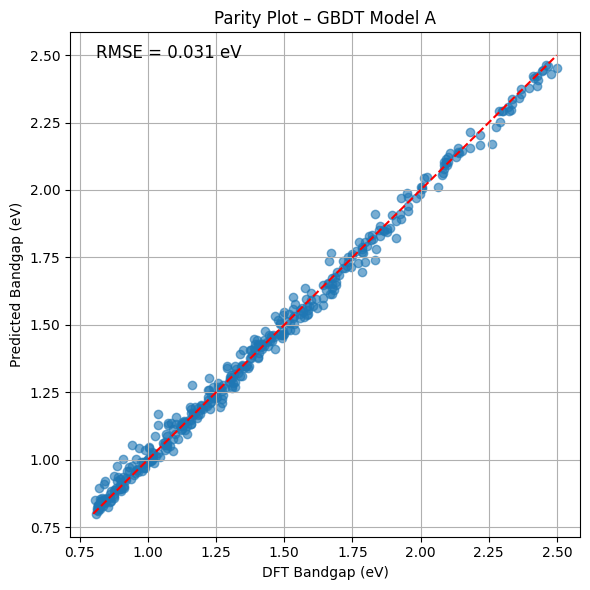

In [46]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.text(
    0.05, 0.95,
    f"RMSE = {rmse:.3f} eV",
    transform=plt.gca().transAxes,
    fontsize=12
)

plt.xlabel("DFT Bandgap (eV)")
plt.ylabel("Predicted Bandgap (eV)")
plt.title("Parity Plot – GBDT Model A")
plt.grid(True)
plt.tight_layout()

# SAVE
plt.savefig(
    "/content/drive/MyDrive/TMDC_ML_Project/parity_plot_gbdt_modelA.png",
    dpi=300
)

plt.show()


In [47]:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingRegressor


In [48]:
gbdt = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=3,
    subsample=0.8,
    random_state=42
)


In [49]:
train_sizes, train_scores, val_scores = learning_curve(
    gbdt,
    X,
    y_true,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring="neg_root_mean_squared_error",
    shuffle=True,
    random_state=42
)


In [50]:
train_rmse = -train_scores.mean(axis=1)
val_rmse = -val_scores.mean(axis=1)


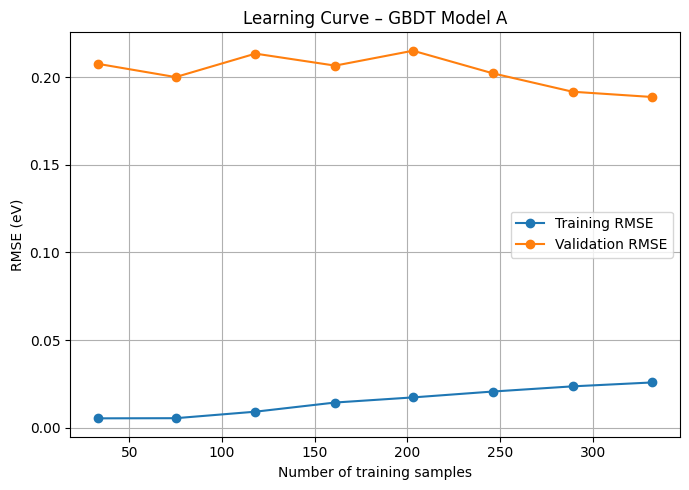

In [51]:
plt.figure(figsize=(7,5))

plt.plot(train_sizes, train_rmse, 'o-', label="Training RMSE")
plt.plot(train_sizes, val_rmse, 'o-', label="Validation RMSE")

plt.xlabel("Number of training samples")
plt.ylabel("RMSE (eV)")
plt.title("Learning Curve – GBDT Model A")
plt.legend()
plt.grid(True)
plt.tight_layout()

# SAVE
plt.savefig(
    "/content/drive/MyDrive/TMDC_ML_Project/learning_curve_gbdt_modelA.png",
    dpi=300
)

plt.show()
